In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapezoid

%matplotlib inline

# Read and display magnetic geometry
- In this example, we read an already extracted geometry from a pickle file and plot the inner and outer leg.
- You will need to prepare your own from an equilibrium or SOLPS balance file using unpackConfigurationsMK.py.



<Axes: xlabel='$S_{\\parallel}$ (m from target)', ylabel='$B_{tot}$ (T)'>

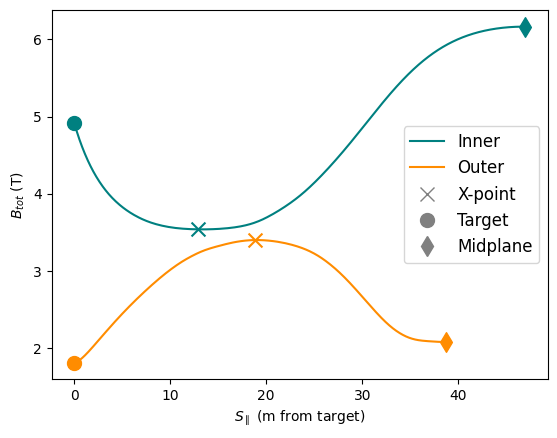

In [13]:
from fusiondls import file_read
from fusiondls.plot import plot_B_field_profile

eqb = file_read("eqb_store.pkl")
inner = eqb["V10"]["iu"]  # Inner upper
outer = eqb["V10"]["ou"]  # Outer upper
plot_B_field_profile(
    inner["S"],
    inner["Btot"],
    inner["Xpoint"],
    outer["S"],
    outer["Btot"],
    outer["Xpoint"],
)

# Run DLS-Extended
- Solving for 5 front positions equally spaced along the parallel connection length for the outer upper target

## Define DLS settings

Running DLS-Extended requires a `MagneticGeometry`, which defines the magnetic profile from the midplane to the target, and a `SimulationInputs`, which defines other simulation settings.

In [14]:
from fusiondls import MagneticGeometry, SimulationInputs
from fusiondls.analytic_cooling_curves import LfuncKallenbach

geometry = MagneticGeometry.from_pickle("eqb_store.pkl", "V10", "ou")

settings = SimulationInputs(
    SparRange=np.linspace(0, geometry.Sx, 5),  # List of S_parallel values to solve for
    gamma_sheath=7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    Tt=0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    qpllu0=1e9,  # heat flux density at the x point
    nu0=1e20,  # Upstream density (if constant)
    cz0=0.02,  # Impurity fraction (if constant)
    upstreamGrid=True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    cooling_curve=LfuncKallenbach("Ar"),  # impurity cooling function
    control_variable="density",  # One of 'density', 'impurity_frac' or 'power'
    Ctol=1e-3,  # Control variable (inner) loop convergence tolerance
    Ttol=1e-3,  # Temperature (outer) loop convergence tolerance
)

## Run

In [15]:
from fusiondls import run_dls

results = run_dls(settings, geometry)

Solving...0.00...4.70...9.39...14.09...18.78...Complete in 10.0 seconds


# Post-processing

## Front position history
- cvar is the control variable we are solving for, in this case density
- crel is the relative control variable (normalised to 1 at threshold) - useful for comparison between cases.

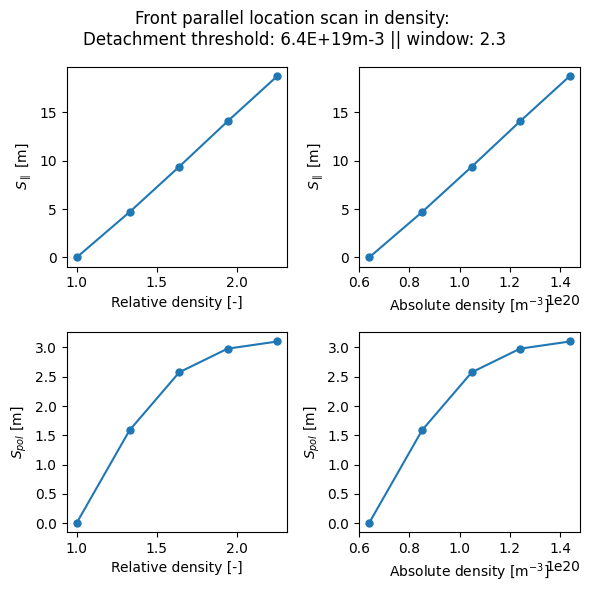

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.suptitle(
    f"Front parallel location scan in density: \nDetachment threshold: {results['threshold']:.1E}m-3 || window: {results['window_ratio']:.1f}",
    fontsize=12,
)

ax = axes[0, 0]
ax.plot(results["crel"], results["Splot"], marker="o", ms=5)

ax = axes[0, 1]
ax.plot(results["cvar"], results["Splot"], marker="o", ms=5)

ax = axes[1, 0]
ax.plot(results["crel"], results["SpolPlot"], marker="o", ms=5)

ax = axes[1, 1]
ax.plot(results["cvar"], results["SpolPlot"], marker="o", ms=5)

[ax.set_ylabel(r"$S_{\parallel}$ [m]") for ax in axes[0, :]]
[ax.set_ylabel(r"$S_{pol}$ [m]") for ax in axes[1, :]]

[ax.set_xlabel(r"Relative density [-]") for ax in axes[:, 0]]
[ax.set_xlabel(r"Absolute density $\mathrm{[m^{-3}]}$") for ax in axes[:, 1]]


fig.tight_layout()

### Tests

Verify that the control variable and parallel position arrays are as expected.

In [17]:
np.testing.assert_allclose(
    results["cvar"],
    [6.39460377e19, 8.50407130e19, 1.04820590e20, 1.24066606e20, 1.43924591e20],
    err_msg="FAIL - front scan test, cvar",
)
np.testing.assert_allclose(
    results["Splot"],
    [0.0, 4.696595511736531, 9.394591286747625, 14.080705311994063, 18.780497037201094],
    err_msg="FAIL - front scan test, Splot",
)

## Profiles of plasma properties for individual front positions
- By default DLS-Extended uses a grid refined around the front location
- This means it's different for each front position
- The profiles of S, Spol as well as process variables (T, qpar/Q, R, etc) are provided on a per front location basis

Text(0.5, 1.05, 'Radiated power, parallel heat flux and temperature for two front positions')

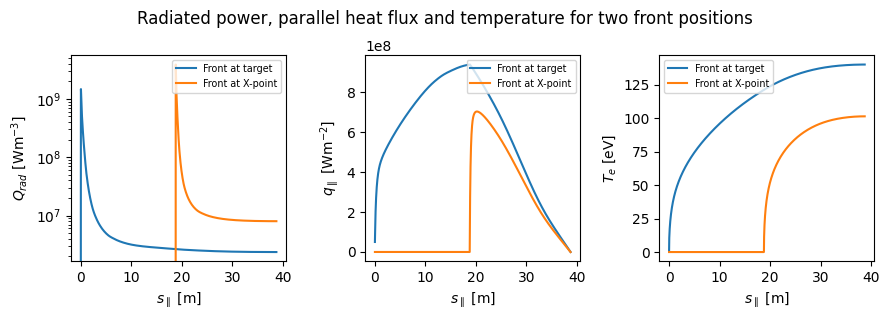

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
labels = ["Front at target", "Front at X-point"]

for i, position_index in enumerate([0, -1]):
    axes[0].plot(
        results["Sprofiles"][position_index],
        results["Rprofiles"][position_index],
        label=labels[i],
    )
    axes[1].plot(
        results["Sprofiles"][position_index],
        results["Qprofiles"][position_index],
        label=labels[i],
    )
    axes[2].plot(
        results["Sprofiles"][position_index],
        results["Tprofiles"][position_index],
        label=labels[i],
    )

axes[0].set_ylabel(r"$Q_{rad}\ \mathrm{[Wm^{-3}]}$")
axes[1].set_ylabel(r"$q_{\parallel}\ \mathrm{[Wm^{-2}]}$")
axes[2].set_ylabel(r"$T_{e}\ \mathrm{[eV]}$")
axes[0].set_yscale("log")
for ax in axes:
    ax.set_xlabel(r"$s_{\parallel}\ \mathrm{[m]}$")
    ax.legend(fontsize="x-small")

fig.tight_layout()
fig.suptitle(
    "Radiated power, parallel heat flux and temperature for two front positions", y=1.05
)

### Tests

Verify that the integrals of the above profiles are as expected.

In [19]:
cases = ["target", "Xpoint"]
integrals = {"radiation": {}, "heatflux": {}, "temperature": {}}

for i, position_index in enumerate([0, -1]):
    Qrad = results["Rprofiles"][position_index]
    S = results["Sprofiles"][position_index]
    qpar = results["Qprofiles"][position_index]
    Te = results["Tprofiles"][position_index]

    name = cases[i]
    integrals["radiation"][name] = trapezoid(Qrad, S)
    integrals["heatflux"][name] = trapezoid(qpar, S)
    integrals["temperature"][name] = trapezoid(Te, S)


reference_integrals = {
    "radiation": {"target": 523226999.38597214, "Xpoint": 894932594.5255164},
    "heatflux": {"target": 23239029534.052227, "Xpoint": 7495964202.588931},
    "temperature": {"target": 4346.077975186298, "Xpoint": 1732.7529664551957},
}

for key, subdict in integrals.items():
    for subkey, value in subdict.items():
        ref_value = reference_integrals[key][subkey]
        np.testing.assert_allclose(
            value, ref_value, err_msg=f"FAIL - {key} profile at {subkey}"
        )